In [1]:
from matplotlib import pyplot as plt
from utils.utils import *
import utils.promethee_functions as pf
import utils.clustering_functions as cf
import utils.eval_metrics as em

utils.py Loading


In [2]:
def dunn_index_multivariate(clusters, data):
    """ 
        Compute the Dunn index for a clustering of multivariate time series data
        - clusters: list of lists of indexes of the time series in each cluster
        - data: the data set (dataframe with index as id of the time series), each cell is a np.array (time series)
    """
    def dunn_index_univariate(clusters, data):
        """
            Compute the Dunn index for a clustering of univariate time series data
            - clusters: list of lists of indexes of the time series in each cluster
            - data: the data set (dataframe with index as id of the time series), only one column where each cell is a np.array (time series)
        """
        centroids = []

        # Define the centroids of the clusters
        for cluster in clusters:
            centroid = np.zeros_like(data.iloc[0])
            for country in cluster:
                centroid += data.loc[country]
            centroid /= len(cluster)
            centroids.append(centroid)

        centroids = np.array(centroids)
        
        # Compute the distances between clusters
        inter_cluster_distances = []
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                inter_cluster_distances.append(np.linalg.norm(centroids[i] - centroids[j]))

        # Compute the diameter of each cluster
        cluster_diameters = []

        # Diameter = avg distance between all pairs of countries in the cluster
        for cluster in clusters:
            diameter = 0
            for i in range(len(cluster)):
                for j in range(i+1, len(cluster)):
                    diameter += np.linalg.norm(data.loc[cluster[i]] - data.loc[cluster[j]])
            diameter /= len(cluster)
            cluster_diameters.append(diameter)


        # # Diameter = max distance between two countries in the cluster
        # for cluster in clusters:
        #     diameter = 0
        #     for i in range(len(cluster)):
        #         for j in range(i+1, len(cluster)):
        #             diameter = max(diameter, np.linalg.norm(data.loc[cluster[i]] - data.loc[cluster[j]]))
        #     cluster_diameters.append(diameter)

        dunn_index = min(inter_cluster_distances) / max(cluster_diameters)
        return dunn_index

    index = 0
    criterias = data.columns

    for criteria in criterias:
        index += dunn_index_univariate(clusters, data[criteria])

    return index / len(criterias)


In [3]:
def p2Kmeans(k, PHI_df):
    """ 
    This function performs the Promethee II method on the data
    Then apply the K-means clustering algorithm on the results
    
    Parameters:
    data (DataFrame): The data to be processed
    W (list): The weights of the criteria
    P (list): The preference function parameters
    Q (list): The indifference function parameters
    K (int): The number of criteria
    L (int): The length of the time series
    """
    results = cf.kMeans(PHI_df, k, max_it=50, distance_function=cf.euclid_distance, random_selec=False)

    # Get a list of list of ISO3 codes for each cluster
    clusters = []
    for i in range(k):
        clusters.append(results[i].index.tolist())
    # print(clusters)

    return clusters

In [4]:
def G_Kmedoid(data, dist_matrix, k=3, prototype_method="random"):
    """ 
    Function that receives the raw dataset and creates the clusters using the K-Medoid algorithm using Promethee Gamma as the distance matrix
    - data: pd.DataFrame with the raw dataset - iso3 as index and the criteria as columns names
    - dist_matrix: pd.DataFrame with the distance matrix - iso3 as index and columns names
    - prototype_method: method to choose the prototype (random, k-means++, etc.)
    - k: number of clusters to create
    """
    # Get the criteria names
    alternatives = data.index

    # # Computing the distance matrix
    # phi_c_all = pf.get_all_Phi_c(data, P, Q, L)
    # eta = pf.get_eta_matrix(data, phi_c_all, W, L)
    # agg_eta = pf.aggregate_all_series(eta, Weight_vector)
    # dist_matrix = pd.DataFrame(agg_eta, index=alternatives, columns=alternatives)

    # Run the K-Medoid algorithm
    medoids, clusters, iter = cf.K_Medoid_Eta(alternatives, dist_matrix, k, prototype_method=prototype_method, print_results=False)

    cluster_list = [val for val in clusters.values()]

    # return medoids, clusters
    return cluster_list


In [5]:
def KMeans_normal(data, k, maxit=5):
    from tslearn.clustering import TimeSeriesKMeans

    n_clusters = k


    n_samples = data.shape[0]
    n_features = data.shape[1]

    formatted_data = np.stack([np.stack(data.iloc[:, i].values) for i in range(n_features)], axis=-1)

    names = data.index
    names_formatted = [name for name in names]

    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=maxit).fit(formatted_data)
   
    clusters = [[] for _ in range(n_clusters)]
    for i in range(n_samples):
        clusters[km.labels_[i]].append(names_formatted[i])

    return clusters

In [6]:
data = read_data()
# Nb of criteria
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series
N = data.index.shape[0] # Nb of countries

W = [1/K for i in range(K)] # Weights of the criteria (equal weights)
Q = [1, 0.03, 5, 0.01, 0.5, 0.5] # Indifference thresholds
P = [10, 0.4, 20, 0.3, 5, 5]

Weight_vector = [1/L for _ in range(L)] # Equal weights times

Reading HDI dataset
co2prod: min=0.0, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=85.473
gdi: min=0.383, max=1.041
eys: min=3.5751, max=23.2477
mys: min=1.4606, max=14.2559


In [7]:
small = True

if small:
    group0 = ["PAK", "SDN", "BDI", "HTI"]
    group1 = ["EST", "CZE", "MLT", "SGP", "IRL"]
    group2 = ["CHE", "ISL", "NZL", "SWE"]
    all_groups = group0 + group1 + group2
    data = data.loc[all_groups]
    N = data.shape[0]

alternatives = data.index # Alternatives are the countries

phi_c_all = pf.get_all_Phi_c(data, P, Q, L) # compute all mono criterion flows series
PHI = pf.PHI_all(phi_c_all, W, N, L, K) # Aggregate to the net flow series
# Transform PHI into a dataframe with ISO3 as index and years as columns
PHI_df = pd.DataFrame(PHI, index=data.index, columns=np.arange(1990, 2023))


eta = pf.get_eta_matrix(data, phi_c_all, W, L)
agg_eta = pf.aggregate_all_series(eta, Weight_vector)
dist_matrix = pd.DataFrame(agg_eta, index=alternatives, columns=alternatives)

c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


In [8]:
def get_results(k, data, dist_matrix, PHI_df, nb_try):

    p2km_results = []
    gkm_results_clusters = []
    trad_km_results = []
    for i in tqdm(range(nb_try)):
        gkm_results_clusters.append(G_Kmedoid(data, dist_matrix, k=k, prototype_method="random"))
        p2km_results.append(p2Kmeans(k, PHI_df))
        trad_km_results.append(KMeans_normal(data, k))
    
    return p2km_results, gkm_results_clusters, trad_km_results

p2km_results, gkm_results_clusters, trad_km_results = get_results(3, data, dist_matrix, PHI_df, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


In [9]:
def evaluate_results_on_data(results, data):
    """ 
    Evaluate the Dunn index of the clustering results on the data
    """
    dunn_indices = []
    for clusters in results:
        dunn_index = dunn_index_multivariate(clusters, data)
        dunn_indices.append(dunn_index)
    
    return dunn_indices

def evaluate_results_on_net_flow_scores(results, PHI_df):
    """ 
    Evaluate the Dunn index of the clustering results on the net flow scores
    """
    dunn_indices = []
    for clusters in results:
        dunn_index = dunn_index_multivariate(clusters, PHI_df)
        dunn_indices.append(dunn_index)
    
    return dunn_indices

C:\Users\raphu\AppData\Local\Temp\ipykernel_11760\1585207261.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([p2km_evaluations, gkm_evaluations, km_evaluations], labels=["P2KMeans", "G-KMedoid", "KMeans"])


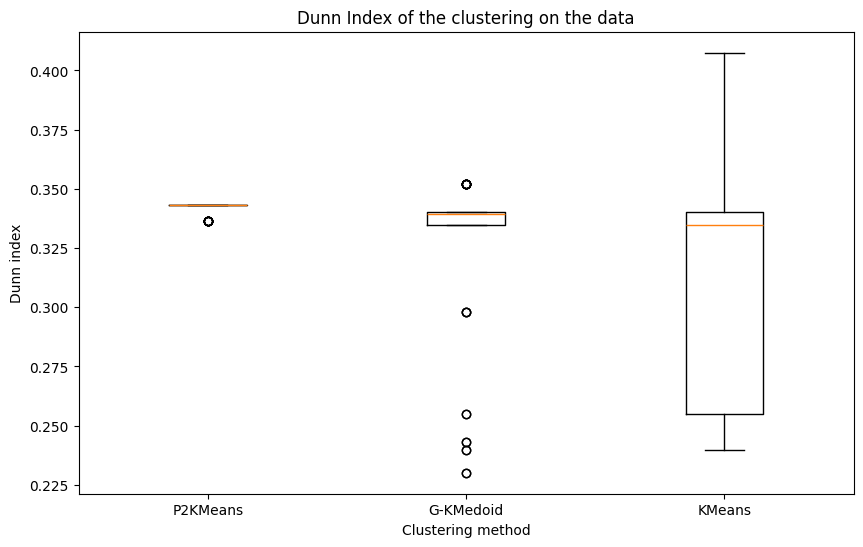

In [10]:
def evaluate_result_repartition_on_data(p2km_clusters, gkm_clusters, km_clusters, data, method=evaluate_results_on_data, title="Dunn Index of the clustering on the data"):
    """ 
    Evaluate the Dunn index of the clustering results on the data
    """
    p2km_evaluations = np.array(method(p2km_clusters, data))
    gkm_evaluations = np.array(method(gkm_clusters, data))
    km_evaluations = np.array(method(km_clusters, data))


    # Plot the Boxplots in order to compare the Dunn index of the three methods
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot([p2km_evaluations, gkm_evaluations, km_evaluations], labels=["P2KMeans", "G-KMedoid", "KMeans"])
    ax.set_title(title)
    ax.set_ylabel("Dunn index")
    ax.set_xlabel("Clustering method")
    plt.show()

evaluate_result_repartition_on_data(p2km_results, gkm_results_clusters, trad_km_results, data, method=evaluate_results_on_data)



C:\Users\raphu\AppData\Local\Temp\ipykernel_11760\1585207261.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([p2km_evaluations, gkm_evaluations, km_evaluations], labels=["P2KMeans", "G-KMedoid", "KMeans"])


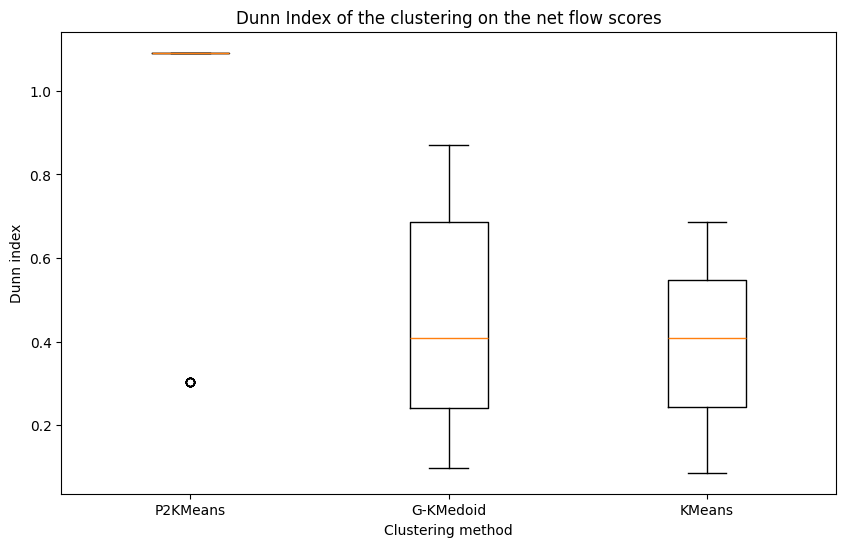

In [11]:
evaluate_result_repartition_on_data(p2km_results, gkm_results_clusters, trad_km_results, PHI_df, method=evaluate_results_on_net_flow_scores, title="Dunn Index of the clustering on the net flow scores")

## 2. On BIG dataset

In [12]:
data = read_data()
# Nb of criteria
K = data.columns.shape[0] # Nb of criteria
L = data.iloc[0]["co2prod"].shape[0] # Length of the time series
N = data.index.shape[0] # Nb of countries

alternatives = data.index # Alternatives are the countries

phi_c_all = pf.get_all_Phi_c(data, P, Q, L) # compute all mono criterion flows series
PHI = pf.PHI_all(phi_c_all, W, N, L, K) # Aggregate to the net flow series
# Transform PHI into a dataframe with ISO3 as index and years as columns
PHI_df = pd.DataFrame(PHI, index=data.index, columns=np.arange(1990, 2023))


eta = pf.get_eta_matrix(data, phi_c_all, W, L)
agg_eta = pf.aggregate_all_series(eta, Weight_vector)
dist_matrix = pd.DataFrame(agg_eta, index=alternatives, columns=alternatives)

Reading HDI dataset
co2prod: min=0.0, max=33.3863
hdi: min=0.257, max=0.967
le: min=37.105, max=85.473
gdi: min=0.383, max=1.041
eys: min=3.5751, max=23.2477
mys: min=1.4606, max=14.2559


c:\Users\raphu\Documents\ULB\MA2\ulb-master-thesis\code\src\utils\promethee_functions.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = a_i[c] - a_j[c]


100%|██████████| 20/20 [00:41<00:00,  2.09s/it]
C:\Users\raphu\AppData\Local\Temp\ipykernel_11760\1585207261.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([p2km_evaluations, gkm_evaluations, km_evaluations], labels=["P2KMeans", "G-KMedoid", "KMeans"])


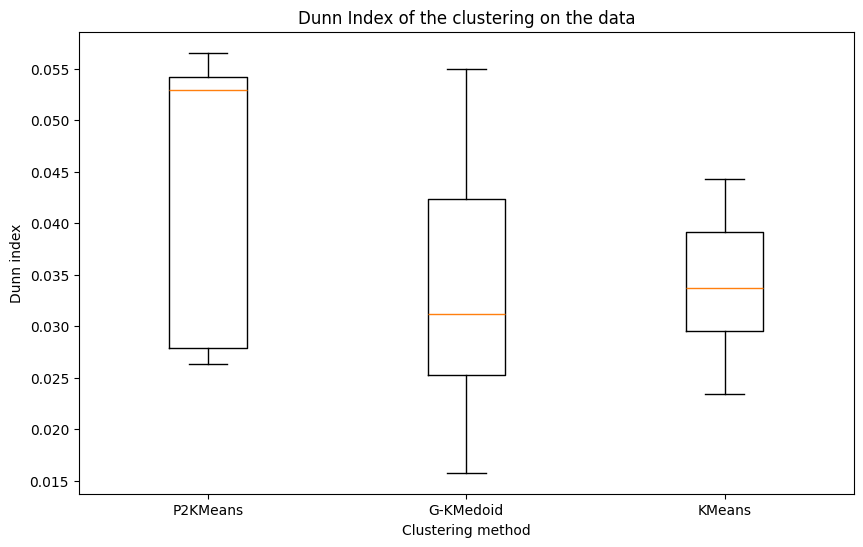

C:\Users\raphu\AppData\Local\Temp\ipykernel_11760\1585207261.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([p2km_evaluations, gkm_evaluations, km_evaluations], labels=["P2KMeans", "G-KMedoid", "KMeans"])


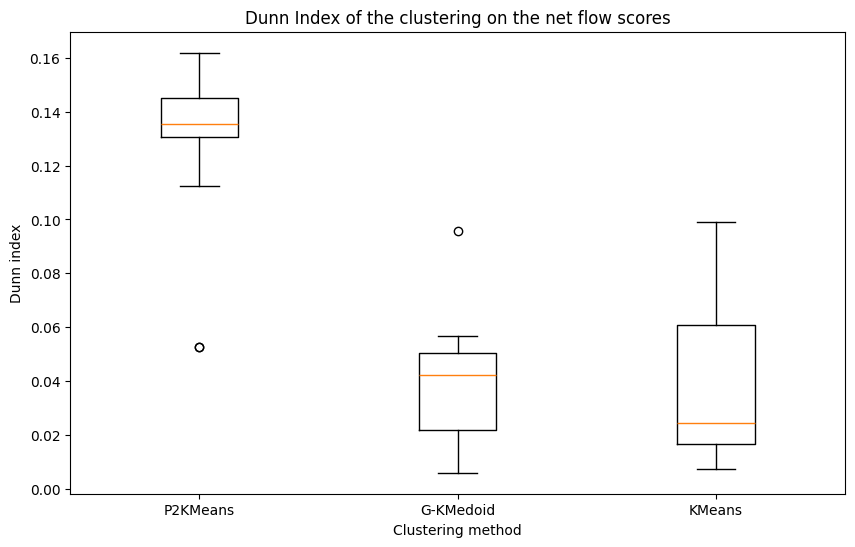

In [13]:
p2km_results, gkm_results_clusters, trad_km_results = get_results(5, data, dist_matrix, PHI_df, 20)

evaluate_result_repartition_on_data(p2km_results, gkm_results_clusters, trad_km_results, data, method=evaluate_results_on_data)
evaluate_result_repartition_on_data(p2km_results, gkm_results_clusters, trad_km_results, PHI_df, method=evaluate_results_on_net_flow_scores, title="Dunn Index of the clustering on the net flow scores")